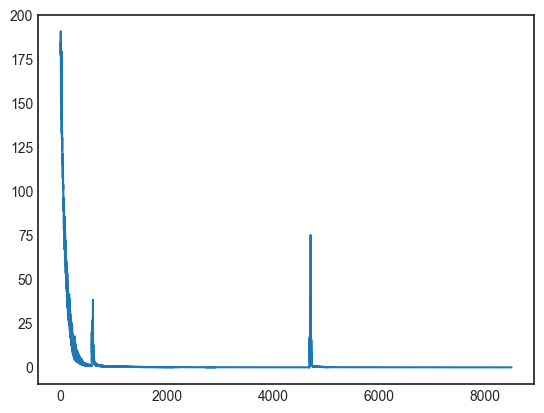

-----
 human speech (such as Siri and Alexa), self-driving cars (e.g., Waymo), generative or creative tools (ChatGPT and AI art), automated decision-making, and competing at the highest level in strategic g
-----
iter 8500, loss 0.104995
Osiągnięto dokładność <= 0.1
Trening zakończony.


In [1]:
# Zajęcie 5: Metoda BPTT dla sieci LSTM

# Importowanie
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import signal
from random import uniform

plt.style.use('seaborn-v0_8-white')

# Odczytywanie i przetwarzanie danych
data = open('zadanie.txt', 'r').read()
chars = list(set(data))
data_size, X_size = len(data), len(chars)
print(f"data has {data_size} characters, {X_size} unique")
char_to_idx = {ch: i for i, ch in enumerate(chars)}
idx_to_char = {i: ch for i, ch in enumerate(chars)}

# Stałe i hiperparametry
H_size = 50               # Size of the hidden layer
T_steps = 50            # Number of time steps (Length of the sequence) used for training
learning_rate = 0.15      # Learning rate
weight_sd = 0.05           # Standard deviation of weights for initialization
z_size = H_size + X_size  # Size of concatenate(H, X) vector

# Funkcje aktywacji i pochodne
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def dsigmoid(y):
    return y * (1 - y)

def tanh(x):
    return np.tanh(x)

def dtanh(y):
    return 1 - y * y

# Parametry
class Param:
    def __init__(self, name, value):
        self.name = name
        self.v = value          # parameter value
        self.d = np.zeros_like(value)  # derivative
        self.m = np.zeros_like(value)  # momentum for AdaGrad

class Parameters:
    def __init__(self):
        self.W_f = Param('W_f', np.random.randn(H_size, z_size) * weight_sd + 0.5)
        self.b_f = Param('b_f', np.zeros((H_size, 1)))
        self.W_i = Param('W_i', np.random.randn(H_size, z_size) * weight_sd + 0.5)
        self.b_i = Param('b_i', np.zeros((H_size, 1)))
        self.W_C = Param('W_C', np.random.randn(H_size, z_size) * weight_sd)
        self.b_C = Param('b_C', np.zeros((H_size, 1)))
        self.W_o = Param('W_o', np.random.randn(H_size, z_size) * weight_sd + 0.5)
        self.b_o = Param('b_o', np.zeros((H_size, 1)))
        # For final layer to predict the next character
        self.W_v = Param('W_v', np.random.randn(X_size, H_size) * weight_sd)
        self.b_v = Param('b_v', np.zeros((X_size, 1)))
    
    def all(self):
        return [self.W_f, self.W_i, self.W_C, self.W_o, self.W_v,
                self.b_f, self.b_i, self.b_C, self.b_o, self.b_v]

parameters = Parameters()

# Obliczanie do przodu
def forward(x, h_prev, C_prev, p=parameters):
    assert x.shape == (X_size, 1)
    assert h_prev.shape == (H_size, 1)
    assert C_prev.shape == (H_size, 1)
    
    z = np.row_stack((h_prev, x))
    
    f = sigmoid(np.dot(p.W_f.v, z) + p.b_f.v)
    i = sigmoid(np.dot(p.W_i.v, z) + p.b_i.v)
    C_bar = tanh(np.dot(p.W_C.v, z) + p.b_C.v)
    C = f * C_prev + i * C_bar
    o = sigmoid(np.dot(p.W_o.v, z) + p.b_o.v)
    h = o * tanh(C)
    
    v = np.dot(p.W_v.v, h) + p.b_v.v
    y = np.exp(v) / np.sum(np.exp(v))  # softmax
    
    return z, f, i, C_bar, C, o, h, v, y

# Obliczanie wstecz
def backward(target, dh_next, dC_next, C_prev, z, f, i, C_bar, C, o, h, v, y, p=parameters):
    assert z.shape == (X_size + H_size, 1)
    assert v.shape == (X_size, 1)
    assert y.shape == (X_size, 1)
    
    for param in [dh_next, dC_next, C_prev, f, i, C_bar, C, o, h]:
        assert param.shape == (H_size, 1)
    
    dv = np.copy(y)
    dv[target] -= 1
    
    p.W_v.d += np.dot(dv, h.T)
    p.b_v.d += dv
    
    dh = np.dot(p.W_v.v.T, dv)
    dh += dh_next
    do = dh * tanh(C)
    do = dsigmoid(o) * do
    p.W_o.d += np.dot(do, z.T)
    p.b_o.d += do
    
    dC = np.copy(dC_next)
    dC += dh * o * dtanh(tanh(C))
    dC_bar = dC * i
    dC_bar = dtanh(C_bar) * dC_bar
    p.W_C.d += np.dot(dC_bar, z.T)
    p.b_C.d += dC_bar
    
    di = dC * C_bar
    di = dsigmoid(i) * di
    p.W_i.d += np.dot(di, z.T)
    p.b_i.d += di
    
    df = dC * C_prev
    df = dsigmoid(f) * df
    p.W_f.d += np.dot(df, z.T)
    p.b_f.d += df
    
    dz = (np.dot(p.W_f.v.T, df) + 
          np.dot(p.W_i.v.T, di) + 
          np.dot(p.W_C.v.T, dC_bar) + 
          np.dot(p.W_o.v.T, do))
    dh_prev = dz[:H_size, :]
    dC_prev = f * dC
    
    return dh_prev, dC_prev

# Pomocnicze funkcje
def clear_gradients(params=parameters):
    for p in params.all():
        p.d.fill(0)

def clip_gradients(params=parameters):
    for p in params.all():
        np.clip(p.d, -1, 1, out=p.d)

# Forward i backward dla całej sekwencji
def forward_backward(inputs, targets, h_prev, C_prev):
    x_s, z_s, f_s, i_s, C_bar_s, C_s, o_s, h_s, v_s, y_s = (
        {}, {}, {}, {}, {}, {}, {}, {}, {}, {})
    
    h_s[-1] = np.copy(h_prev)
    C_s[-1] = np.copy(C_prev)
    
    loss = 0
    
    # Forward pass
    for t in range(len(inputs)):
        x_s[t] = np.zeros((X_size, 1))
        x_s[t][inputs[t]] = 1
        
        (z_s[t], f_s[t], i_s[t], C_bar_s[t], 
         C_s[t], o_s[t], h_s[t], v_s[t], y_s[t]) = forward(x_s[t], h_s[t-1], C_s[t-1])
        
        loss += -np.log(y_s[t][targets[t], 0])
    
    clear_gradients()
    dh_next = np.zeros_like(h_s[0])
    dC_next = np.zeros_like(C_s[0])
    
    # Backward pass
    for t in reversed(range(len(inputs))):
        dh_next, dC_next = backward(
            target=targets[t], 
            dh_next=dh_next, 
            dC_next=dC_next, 
            C_prev=C_s[t-1],
            z=z_s[t], 
            f=f_s[t], 
            i=i_s[t], 
            C_bar=C_bar_s[t],
            C=C_s[t], 
            o=o_s[t], 
            h=h_s[t], 
            v=v_s[t],
            y=y_s[t]
        )
    
    clip_gradients()
    return loss, h_s[len(inputs)-1], C_s[len(inputs)-1]

# Generowanie tekstu
def sample(h_prev, C_prev, first_char_idx, sentence_length):
    x = np.zeros((X_size, 1))
    x[first_char_idx] = 1
    h = h_prev
    C = C_prev
    indexes = []
    
    for t in range(sentence_length):
        _, _, _, _, C, _, h, _, p = forward(x, h, C)
        idx = np.random.choice(range(X_size), p=p.ravel())
        x = np.zeros((X_size, 1))
        x[idx] = 1
        indexes.append(idx)
    
    return indexes

# Status i aktualizacja
def update_status(inputs, h_prev, C_prev):
    global plot_iter, plot_loss, smooth_loss, iteration
    
    sample_idx = sample(h_prev, C_prev, inputs[0], 200)
    txt = ''.join(idx_to_char[idx] for idx in sample_idx)
    
    plt.plot(plot_iter, plot_loss)
    display.clear_output(wait=True)
    plt.show()
    
    print("-----\n%s\n-----" % txt)
    print("iter %d, loss %f" % (iteration, smooth_loss))

def update_parameters(params=parameters):
    for p in params.all():
        p.m += p.d * p.d
        p.v += -(learning_rate * p.d / np.sqrt(p.m + 1e-8))

# Opóźnione przerwanie klawiatury
class DelayedKeyboardInterrupt:
    def __enter__(self):
        self.signal_received = False
        self.old_handler = signal.signal(signal.SIGINT, self.handler)
    
    def handler(self, sig, frame):
        self.signal_received = (sig, frame)
        print('SIGINT received. Delaying KeyboardInterrupt.')
    
    def __exit__(self, type, value, traceback):
        signal.signal(signal.SIGINT, self.old_handler)
        if self.signal_received:
            self.old_handler(*self.signal_received)

# Inicjalizacja zmiennych treningowych
smooth_loss = -np.log(1.0 / X_size) * T_steps
iteration, pointer = 0, 0
plot_iter = np.zeros((0))
plot_loss = np.zeros((0))

# Pętla treningowa
while True:
    try:
        with DelayedKeyboardInterrupt():
            if pointer + T_steps >= len(data) or iteration == 0:
                g_h_prev = np.zeros((H_size, 1))
                g_C_prev = np.zeros((H_size, 1))
                pointer = 0
            
            inputs = [char_to_idx[ch] for ch in data[pointer: pointer + T_steps]]
            targets = [char_to_idx[ch] for ch in data[pointer + 1: pointer + T_steps + 1]]
            
            loss, g_h_prev, g_C_prev = forward_backward(inputs, targets, g_h_prev, g_C_prev)
            smooth_loss = smooth_loss * 0.999 + loss * 0.001

            if smooth_loss <= 0.1:
                print("Osiągnięto dokładność <= 0.1")
                break
            
            if iteration % 100 == 0:
                update_status(inputs, g_h_prev, g_C_prev)
            
            update_parameters()
            
            plot_iter = np.append(plot_iter, [iteration])
            plot_loss = np.append(plot_loss, [loss])
            
            pointer += T_steps
            iteration += 1     
    except KeyboardInterrupt:
        update_status(inputs, g_h_prev, g_C_prev)
        break

print("Trening zakończony.")

# Sprawdzanie gradientu (opcjonalne)
def calc_numerical_gradient(param, idx, delta, inputs, targets, h_prev, C_prev):
    old_val = param.v.flat[idx]
    
    param.v.flat[idx] = old_val + delta
    loss_plus_delta, _, _ = forward_backward(inputs, targets, h_prev, C_prev)
    
    param.v.flat[idx] = old_val - delta
    loss_mins_delta, _, _ = forward_backward(inputs, targets, h_prev, C_prev)
    
    param.v.flat[idx] = old_val
    
    grad_numerical = (loss_plus_delta - loss_mins_delta) / (2 * delta)
    grad_numerical = np.clip([grad_numerical], -1, 1)[0]
    
    return grad_numerical

def gradient_check(num_checks, delta, inputs, targets, h_prev, C_prev):
    _, _, _ = forward_backward(inputs, targets, h_prev, C_prev)
    
    for param in parameters.all():
        d_copy = np.copy(param.d)
        
        for i in range(num_checks):
            rnd_idx = int(uniform(0, param.v.size))
            
            grad_numerical = calc_numerical_gradient(param, rnd_idx, delta, inputs, targets, h_prev, C_prev)
            grad_analytical = d_copy.flat[rnd_idx]
            
            err_sum = abs(grad_numerical + grad_analytical) + 1e-09
            rel_error = abs(grad_analytical - grad_numerical) / err_sum
            
            if rel_error > 1e-06:
                print('%s (%e, %e) => %e' % (param.name, grad_numerical, grad_analytical, rel_error))